In [2]:
from environment import NormalMoveEnv
from experiment import Experiment
from nn import BetaModel, Model, GeneralModel
from rl import Agent, Trajectory

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

# %matplotlib inline

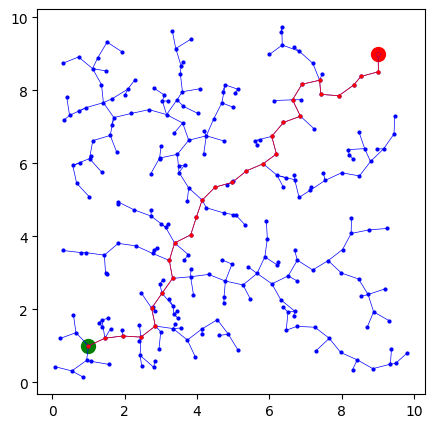

In [22]:
class Node:
    def __init__(self, value, parent=None, cost=0):
        self.value = value
        self.cost = cost
        self.parent = parent
        self.children = []

class RRT:
    def __init__(self, start, goal, max_step_size=0.5):
        self.tree = Node(start)
        self.start = start
        self.goal = goal
        self.max_step_size = max_step_size
        self.path = None

    def explore(self, max_iterations=500):
        for _ in range(max_iterations):
            random_point = np.random.rand(2) * 10

            nearest_node = self.find_nearest(random_point)
            new_node = self.extend(nearest_node, random_point)
            
            goal_distance = np.linalg.norm(new_node.value - self.goal)
            if goal_distance < self.max_step_size:
                self.path = Node(self.goal, new_node, new_node.cost+goal_distance)
                new_node.children.append(self.path)
                break
        return self.path

    def find_nearest(self, point, tree=None):
        node = tree or self.tree
        best = node
        best_distance = np.linalg.norm(np.array(best.value) - np.array(point))
        for child in node.children:
            node = self.find_nearest(point, child)
            distance = np.linalg.norm(np.array(node.value) - np.array(point))
            if distance < best_distance:
                best_distance = distance
                best = node
        return best

    def extend(self, from_node, to_point):
        direction = to_point - from_node.value
        distance = np.linalg.norm(direction)
        if distance > self.max_step_size:
            direction = direction / distance * self.max_step_size

        new_node = Node(from_node.value + direction, from_node, from_node.cost+(self.max_step_size if distance > self.max_step_size else distance))
        from_node.children.append(new_node)
        return new_node
    
    def plot(self, ax=None):
        if ax is None:
            _, ax = plt.subplots(figsize=(5, 5))
        ax.plot(self.start[0], self.start[1], 'go', markersize=10)
        ax.plot(self.goal[0], self.goal[1], 'ro', markersize=10)
        
        def plt_node(tree):
            ax.plot(tree.value[0], tree.value[1], 'bo', markersize=2)
            if tree.parent is not None:
                ax.plot([tree.parent.value[0], tree.value[0]], [tree.parent.value[1], tree.value[1]], 'b-', linewidth=.5)
            for child in tree.children:
                plt_node(child)
        def plt_path(node):
            ax.plot(node.value[0], node.value[1], 'ro', markersize=2)
            if node.parent is not None:
                ax.plot([node.parent.value[0], node.value[0]], [node.parent.value[1], node.value[1]], 'r-', linewidth=.5)
            if node.parent is not None:
                plt_path(node.parent)

        plt_node(self.tree)
        if self.path is not None:
            plt_path(self.path)


start_point = np.array([1, 1])
goal_point = np.array([9, 9])

rrt_tree = RRT(start_point, goal_point)
rrt_tree.explore()
rrt_tree.plot()

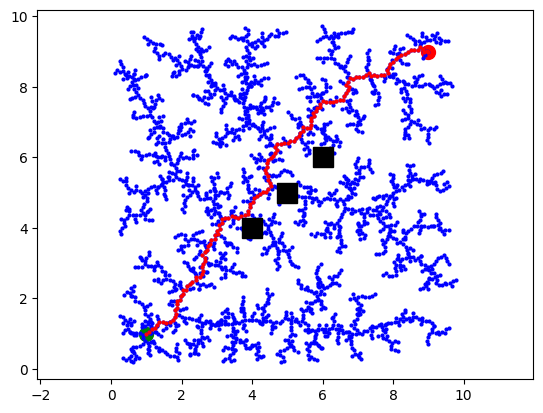

In [26]:
import numpy as np
import matplotlib.pyplot as plt

class Node:
    def __init__(self, value, parent=None, cost=0):
        self.value = value
        self.cost = cost
        self.parent = parent
        self.children = []

def rrt_star(start, goal, obstacles, iterations=1000, step_size=0.1, rad=.5):
    tree = Node(start)
    end = None

    for _ in range(iterations):
        random_point = np.random.rand(2) * 10

        nearest_node = find_nearest(tree, random_point)
        new_node = extend(nearest_node, random_point, step_size)
        
        # neighbors = find_neighbors(tree, new_node, rad)
        # for neighbor in neighbors:
        #     distance = np.linalg.norm(neighbor.value - new_node.value)
        #     if new_node.cost + distance < neighbor.cost:
        #         neighbor.cost = new_node.cost + distance
        #         neighbor.parent.children.remove(neighbor)
        #         neighbor.parent = new_node
        #         neighbor.parent.children.append(neighbor)

        goal_distance = np.linalg.norm(new_node.value - goal)
        if goal_distance < step_size:
            # Se o novo ponto estiver próximo o suficiente do objetivo, conecte diretamente
            end = Node(goal, new_node, new_node.cost+goal_distance)
            new_node.children.append(end)
            break

    return tree, end

def find_neighbors(tree, node, rad):
    neighbors = []

    dist = np.linalg.norm(node.value - tree.value)
    if dist <= rad:
        neighbors.append(tree)

    for child in tree.children:
        child_neighbors = find_neighbors(child, node, rad)
        neighbors = neighbors + child_neighbors

    return neighbors

def find_nearest(tree, point):
    node = tree
    best = node
    best_distance = np.linalg.norm(np.array(best.value) - np.array(point))
    for child in node.children:
        node = find_nearest(child, point)
        distance = np.linalg.norm(np.array(node.value) - np.array(point))
        if distance < best_distance:
            best_distance = distance
            best = node
    return best

def extend(from_node, to_point, max_distance):
    direction = to_point - from_node.value
    distance = np.linalg.norm(direction)
    if distance > max_distance:
        direction = direction / distance * max_distance

    new_node = Node(from_node.value + direction, from_node, from_node.cost+(max_distance if distance > max_distance else distance))
    from_node.children.append(new_node)
    return new_node

def is_collision(point, obstacles):
    for obstacle in obstacles:
        if np.linalg.norm(point - obstacle) < 1.0:
            return True
    return False

def plot_rrt(tree, end, start, goal, obstacles):
    plt.figure()
    plt.plot(start[0], start[1], 'go', markersize=10)
    plt.plot(goal[0], goal[1], 'ro', markersize=10)
    
    def plt_node(tree):
        plt.plot(tree.value[0], tree.value[1], 'bo', markersize=2)
        for child in tree.children:
            plt_node(child)
    def plt_path(node):
        plt.plot(node.value[0], node.value[1], 'ro', markersize=2)
        if node.parent is not None:
            plt_path(node.parent)

    plt_node(tree)
    if end is not None:
        plt_path(end)

    for obstacle in obstacles:
        plt.plot(obstacle[0], obstacle[1], 'ks', markersize=15)

    plt.axis('equal')
    plt.show()

# Exemplo de uso:
start_point = np.array([1, 1])
goal_point = np.array([9, 9])
obstacle_points = [np.array([4, 4]), np.array([5, 5]), np.array([6, 6])]

rrt_tree, end_node = rrt_star(start_point, goal_point, obstacle_points, iterations=3000)
plot_rrt(rrt_tree, end_node, start_point, goal_point, obstacle_points)